# Determining Properties of Galaxies Using Machine Learning

---
## Jorge Bermeo, Nathanael Gutierrez, Tokhirjon Malikov

## Table of Contents
1. [Summary](#abstract)
1. [Learning Set](#learning-set)
1. [Predictions](#predictions)
    1. [Predicting age](#PREDICTING-AGE)
    1. [Predicting tau](#predicting-tau)
    1. [Predicting mass](#PREDICTING-MASS)
    1. [Predicting dust](#predicting-dust)
1. [Adding Noise](#adding-noise)
    1. [Age](#age-noise)
    1. [Tau](#tau-noise)
    1. [Mass](#mass-noise)
    1. [Dust](#dust-noise)
1. [References](#references)

---
## SUMMARY

SUMMARY GOES HERE

---

## LEARNING SET

SHORT DESCRIPTION OF OUR LEARNING SET GOES HERE

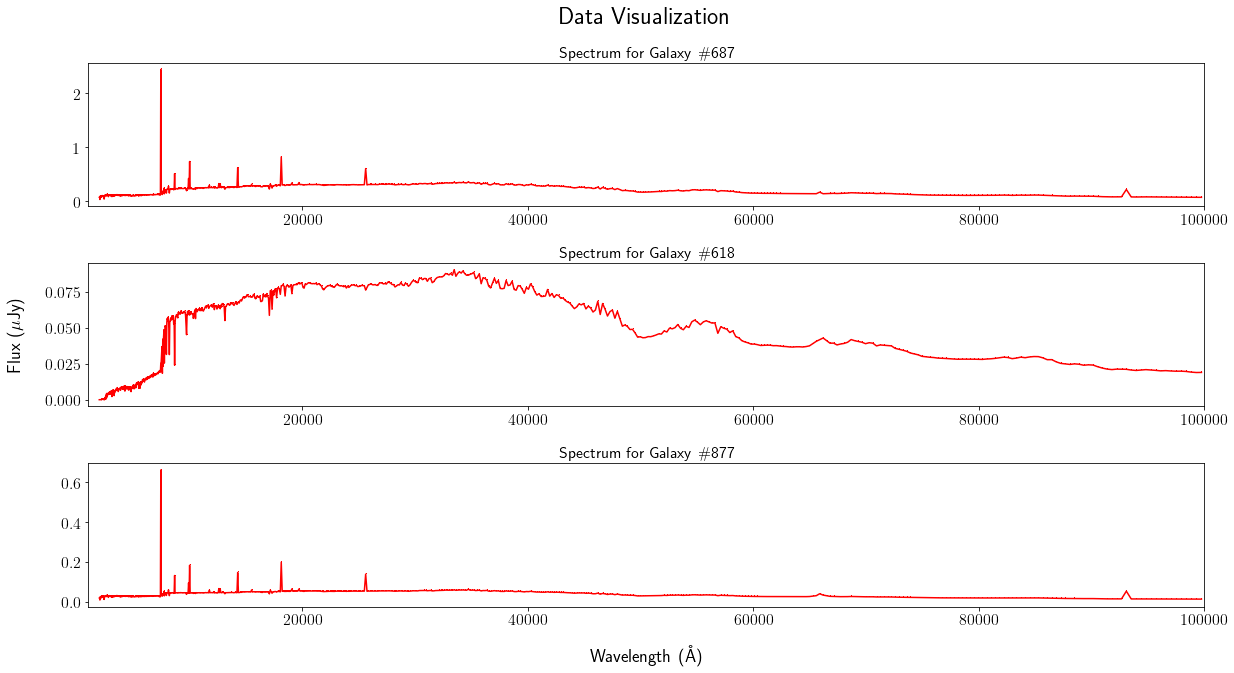

In [64]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
matplotlib.rcParams['text.usetex'] = True

spectra = pd.read_csv('spectra.dat', delimiter=' ', header=None)
wavelengths = pd.read_csv('wavelengths.csv', header=None)
galaxy_properties = pd.read_csv('galaxy_properties.csv', index_col = 0)

random.seed(1010) # for reproducibility
rows = [random.randint(0, len(spectra)) for i in range(3)]  # select three random galaxy spectrums to visualize

plt.rcParams["figure.figsize"] = (20,10) #set size of plot
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

fig = plt.figure()
ax = fig.add_subplot(111) # Generating subplots for our figure; see https://stackoverflow.com/a/6981055/3135556
ax1 = fig.add_subplot(311) # 3 rows, 1 column, plot at position 1
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.plot(wavelengths, spectra.loc[rows[0]], 'r,-')
ax2.plot(wavelengths, spectra.loc[rows[1]], 'r,-')
ax3.plot(wavelengths, spectra.loc[rows[2]], 'r,-')

ax1.set_xlim(1000, 100000) # restrict the x-axis to mitigate the gap that exists around x=0
ax2.set_xlim(1000, 100000)
ax3.set_xlim(1000, 100000)

# Set common labels
ax.set_xlabel("Wavelength (Å)", fontsize=18, labelpad=18)
ax.set_ylabel("Flux ($\mathrm{\mu}$Jy)", fontsize=18, labelpad=36)
ax.set_title("Data Visualization", fontsize=24, pad=40)

ax1.set_title("Spectrum for Galaxy \#" + str(rows[0]), fontsize=16)
ax2.set_title("Spectrum for Galaxy \#" + str(rows[1]), fontsize=16)
ax3.set_title("Spectrum for Galaxy \#" + str(rows[2]), fontsize=16)

plt.subplots_adjust(hspace=0.4) # increase vertical distance between subplots
fig.savefig("visualization.png")

## Helper functions

In [12]:
def dtt(values, val_type='pd'):
    """
    Do The Thing -- takes the log of the sum of each row in 'values'
    Returns a NumPy array with as many values as the number of rows in 'values'
    
    Positional arguments:
        values -- a Pandas DataFrame or NumPy array
        
    Optional arguments:
        val_type -- 'pd' if 'values' is a Pandas DataFrame, 'np' if 'values' is a NumPy array
    """
    
    X = np.empty(len(values))
    
    if (val_type == 'pd'):
        for i in range(len(values)):
            X[i] = np.log(np.sum(values.iloc[i]))
    elif (val_type == 'np'):
        for i in range(len(values)):
            X[i] = np.log(np.sum(values[i]))
    else:
        raise ValueError("Expecting val_type to be either 'pd' or 'np'")
    
    return X

In [47]:
def plot_model_performance(X, y_expected, y_predicted, ylabel, **kwargs):
    params = {
        'actual_color': 'red',
        'predicted_color': 'blue',
        'actual_label': 'Actual values',
        'predicted_label': 'Predicted values',
        'title': 'Model Perfomance',
        'xlabel': '$\log (\sum\limits_{i\in\{\mathrm{Spectrum}\}} \mathrm{Spectrum}_i)$',
        'save_fig': False,
        'save_fig_as': '',
        'scores': None,
        'scores_loc': (0.01, 0.98),
    }
    
    for key, value in kwargs.items():
        if key not in params:
            raise ValueError("Keyword argument '" + key + "' not in list of acceptable parameters.")
        params[key] = value
    
    fig, ax = plt.subplots()
    ax.scatter(X, y_expected, color=params['actual_color'], label=params['actual_label'], alpha=0.6)
    plt.scatter(X, y_predicted, color=params['predicted_color'], label=params['predicted_label'], alpha=0.6)
    ax.legend()
    ax.set_title(params['title'], fontsize=20, pad=10)
    ax.set_ylabel(ylabel, fontsize=16, labelpad=14)
    ax.set_xlabel(params['xlabel'], fontsize=16, labelpad=14)
    
    if params['scores'] is not None:
        props = dict(boxstyle='round', facecolor='silver', alpha=0.5)
        text = 'Training Results\n\n'
        for key, value in params['scores'].items():
            text = text + ' = '.join((key, '%.3f' % (value, ))) + '\n'
        loc = params['scores_loc']
        ax.text(loc[0], loc[1], text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    if params['save_fig']:
        if params['save_fig_as'] == '':
            params['save_fig_as'] = 'Model Performance - ' + ylabel
        fig.savefig(params['save_fig_as'], dpi=300)

In [76]:
def plot_model_training_performance(true_labels, predicted_labels, axis=None, **kwargs):
    params = {
        'label': '',
        'save_fig': False,
        'save_fig_as': None,
        'scores': None,
        'scores_loc': (0.01, 0.98),
        'return_plot': False,
    }
    
    for key, value in kwargs.items():
        if key not in params:
            raise ValueError("Keyword argument '" + key + "' not in list of acceptable parameters.")
        params[key] = value
        
    title = params['label'] + ' Model Training Performance'
    
    if axis == None:
        fig, ax = plt.subplots()
    else:
        fig = plt.figure()
        ax = axis
    
    ax.scatter(predicted_labels, true_labels, color='orange', s=50)
    ax.plot([true_labels.min(), true_labels.max()], [true_labels.min(), true_labels.max()], 'k--', lw=4)
    ax.set_title(title.strip(), fontsize=20, pad=10)
    ax.set_ylabel('True values', fontsize=16, labelpad=14)
    ax.set_xlabel('Predicted values', fontsize=16, labelpad=14)
    
    if params['scores'] is not None:
        props = dict(boxstyle='round', facecolor='silver', alpha=0.5)
        text = 'Mean Training Results\n\n'
        for key, value in params['scores'].items():
            text = text + ' = '.join((key, '%.3f' % (value, ))) + '\n'
        loc = params['scores_loc']
        ax.text(loc[0], loc[1], text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    if axis == None:
        if params['save_fig']:
            if params['save_fig_as'] == None:
                params['save_fig_as'] = title
            fig.savefig(params['save_fig_as'], dpi=300)
        
        if params['return_plot']:
            return fig

In [40]:
from sklearn.model_selection import KFold

spectra_X = dtt(spectra)
cv = KFold(n_splits=5, shuffle=True, random_state=101)

In [16]:
def visualize(Y, ylabel, title, X=spectra_X, xlabel='$\log (\sum\limits_{i\in\{\mathrm{Spectrum}\}} \mathrm{Spectrum}_i)$', save_fig=False, save_as=None):
    plt.scatter(X, Y)
    plt.title(title, fontsize=20, pad=10)
    plt.xlabel(xlabel, fontsize=16, labelpad=14)
    plt.ylabel(ylabel, fontsize=16, labelpad=14)
    if save_fig == True:
        if save_as == None:
            save_as = title
        plt.savefig(save_as, dpi=300)

## PREDICTING AGE

SHORT BLURB GOES HERE

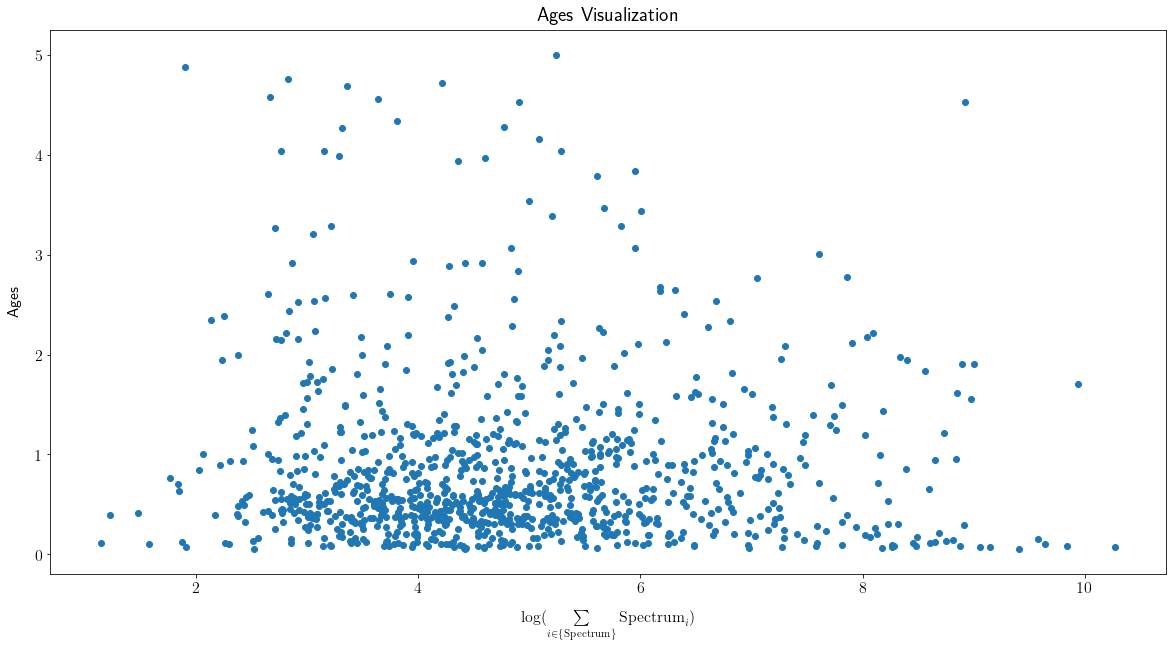

In [48]:
ages = galaxy_properties['age']
visualize(ages, 'Ages', 'Ages Visualization', save_fig=True)

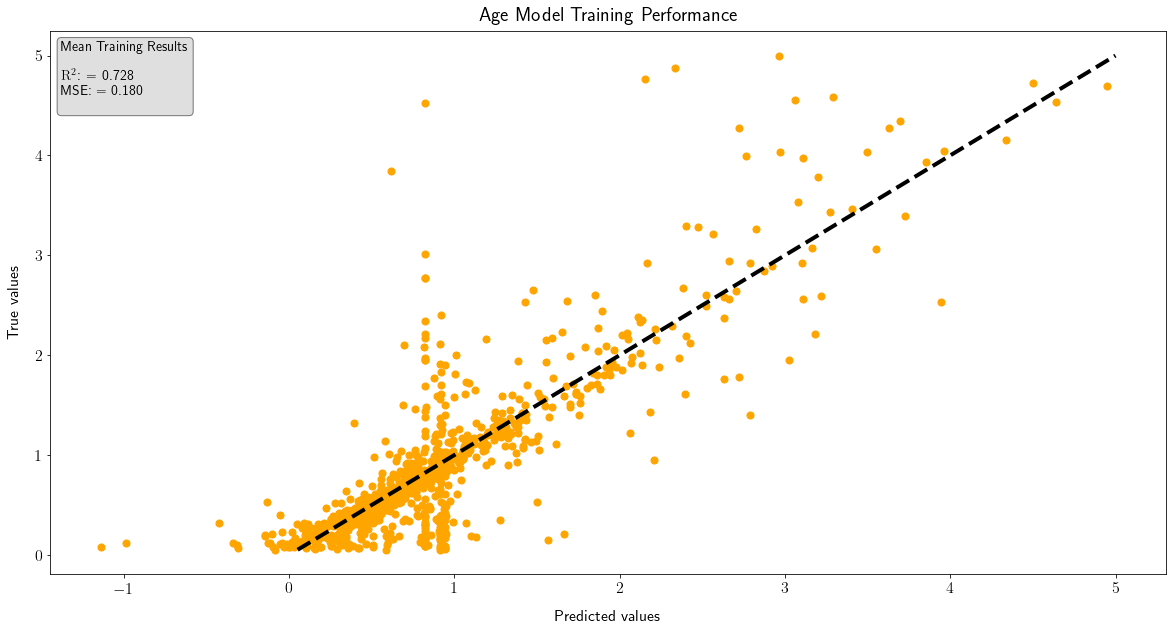

In [72]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.svm import SVR

age_model = SVR(C=2300, gamma=0.08, kernel='rbf')
cv_scores = cross_validate(age_model, spectra, ages, cv=cv, scoring=['r2', 'neg_mean_squared_error'], n_jobs=-1, return_estimator=True)
prediction = cross_val_predict(age_model, spectra, ages, cv=cv, n_jobs=-1)

estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()]

scores = {
     '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
     'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
}

plot_model_training_performance(ages, prediction, label='Age', scores=scores, save_fig=True)

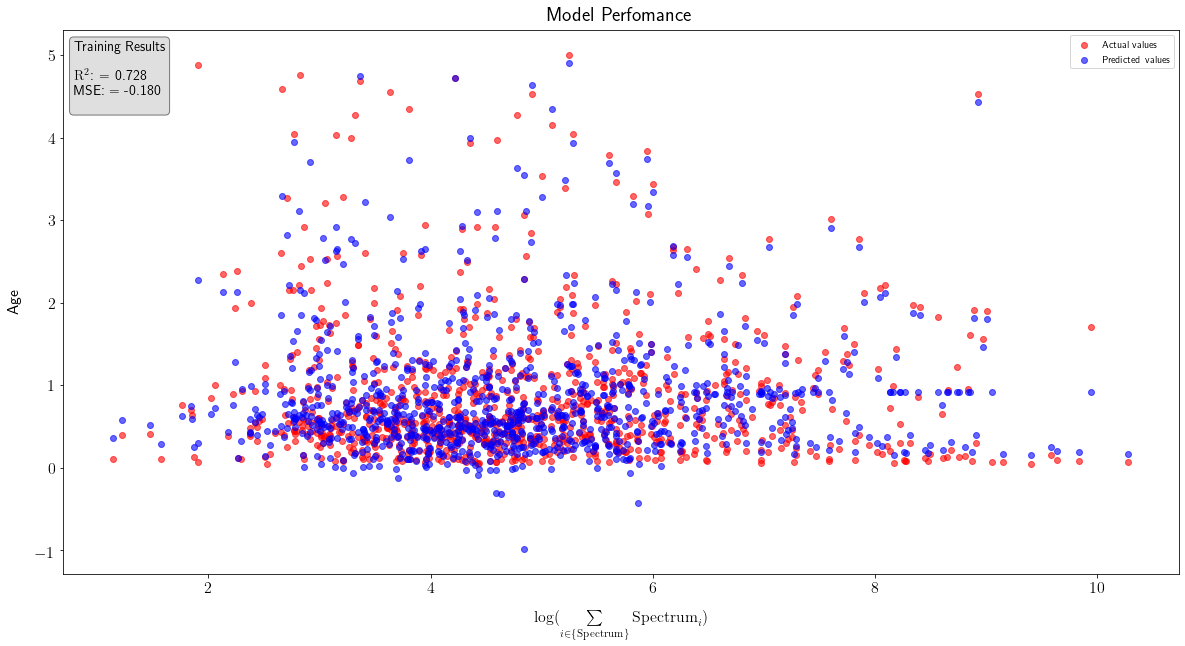

In [50]:
plot_model_performance(spectra_X, ages, estimator.predict(spectra), 'Age', scores=scores, save_fig=True)

## PREDICTING MASS

SHORT BLURB GOES HERE

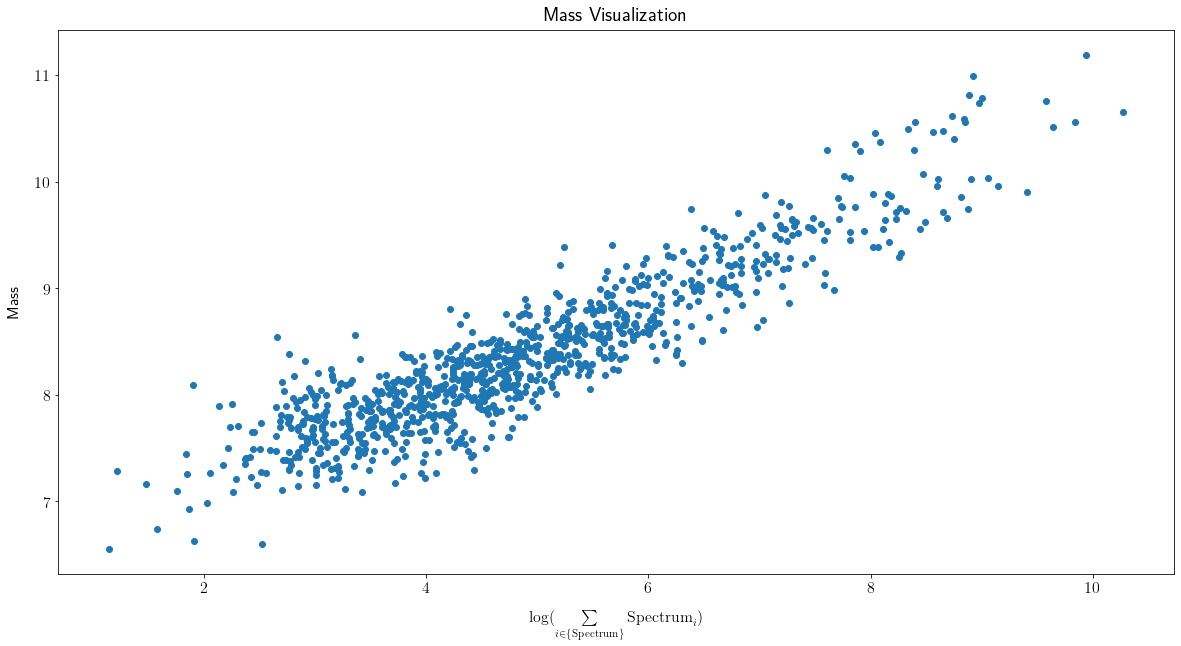

In [51]:
mass = galaxy_properties['mass']
visualize(mass, 'Mass', 'Mass Visualization', save_fig=True)

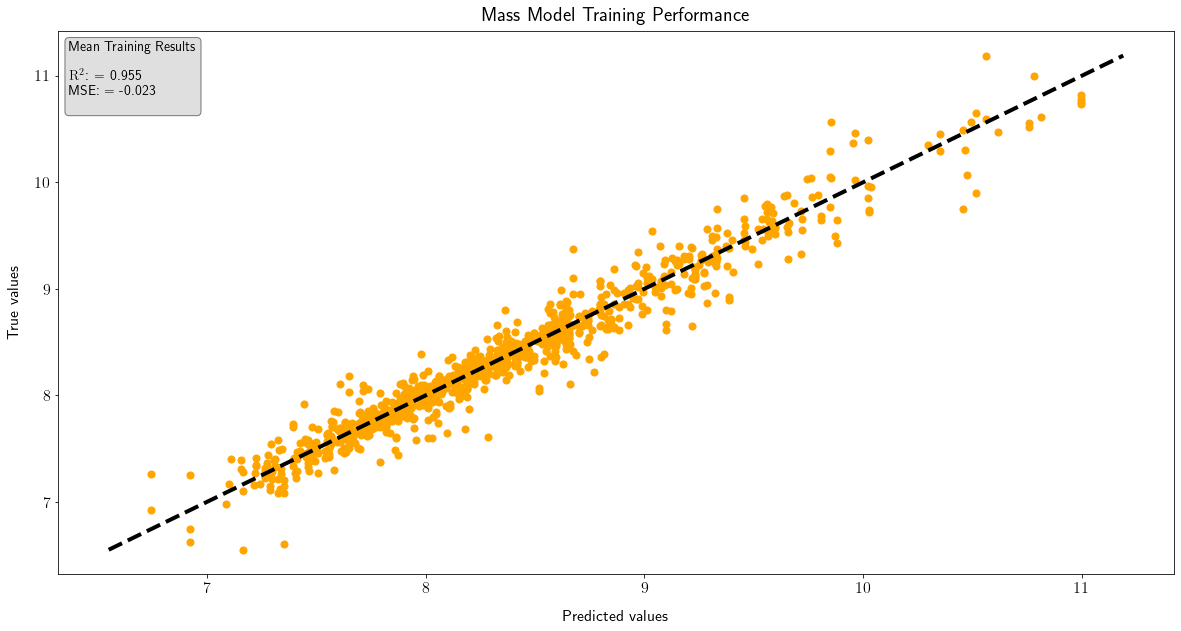

In [53]:
from sklearn.tree import DecisionTreeRegressor

mass_model = DecisionTreeRegressor(max_features=803)
cv_scores = cross_validate(mass_model, spectra, mass, cv=cv, scoring=['r2', 'neg_mean_squared_error'], n_jobs=-1, return_estimator=True)
prediction = cross_val_predict(mass_model, spectra, mass, cv=cv, n_jobs=-1)

estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()]

scores = {
     '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
     'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
}

plot_model_training_performance(mass, prediction, label='Mass', scores=scores, save_fig=True)

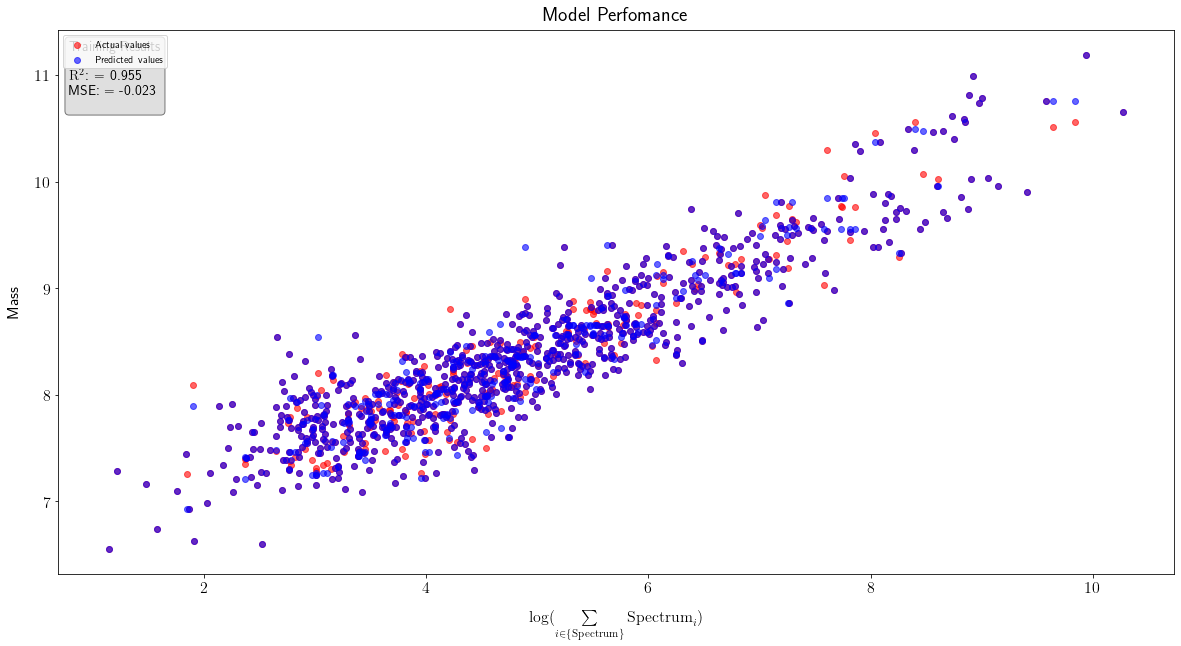

In [54]:
plot_model_performance(spectra_X, mass, estimator.predict(spectra), 'Mass', scores=scores, save_fig=True)

## PREDICTING TAU

SHORT BLURB GOES HERE

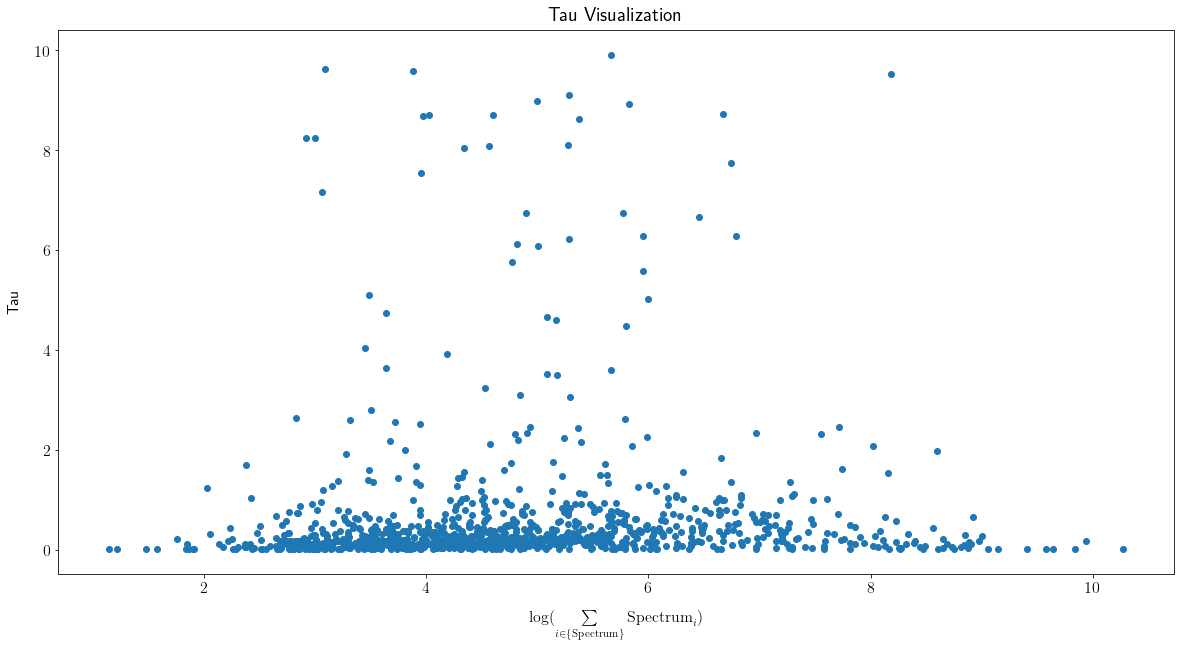

In [55]:
tau = galaxy_properties['tauGyr']
visualize(tau, 'Tau', 'Tau Visualization', save_fig=True)

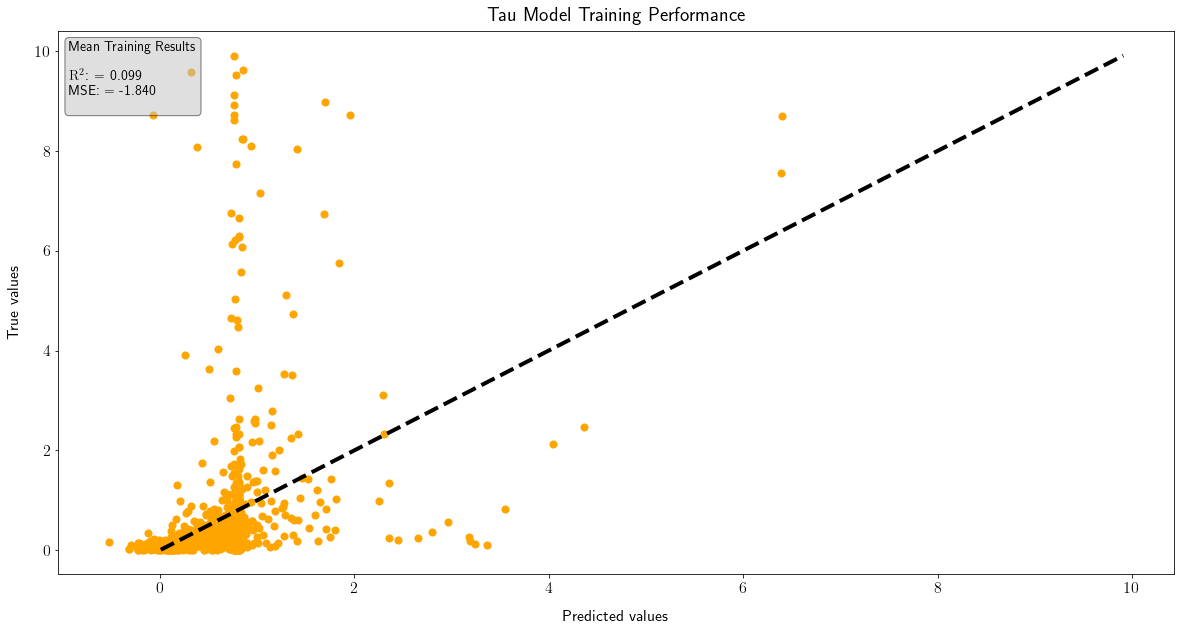

In [56]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svr = SVR(C=10, gamma=16, kernel='rbf')
tau_model = make_pipeline(StandardScaler(), svr)
cv_scores = cross_validate(tau_model, spectra, tau, cv=cv, scoring=['r2', 'neg_mean_squared_error'], n_jobs=-1, return_estimator=True)
prediction = cross_val_predict(tau_model, spectra, tau, cv=cv, n_jobs=-1)

estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()]

scores = {
     '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
     'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
}

plot_model_training_performance(tau, prediction, label='Tau', scores=scores, save_fig=True)

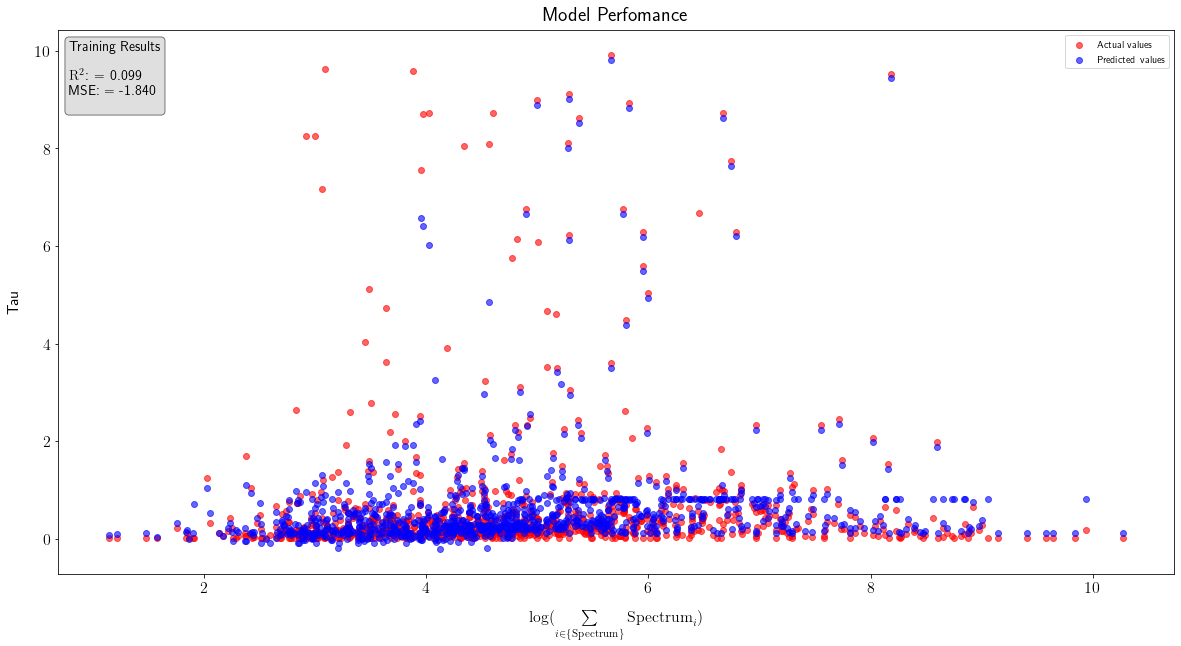

In [58]:
plot_model_performance(spectra_X, tau, estimator.predict(spectra), 'Tau', scores=scores, save_fig=True)

## PREDICTING DUST

SHORT BLURB GOES HERE

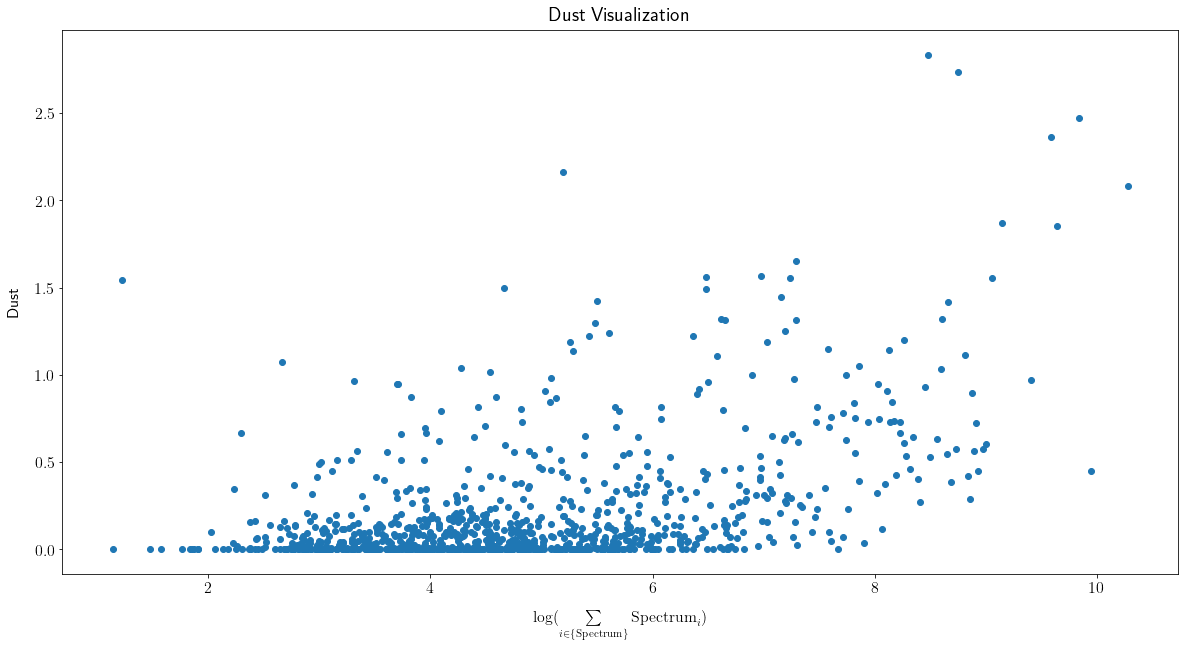

In [59]:
dust = galaxy_properties['dust_av']
visualize(dust, 'Dust', 'Dust Visualization', save_fig=True)

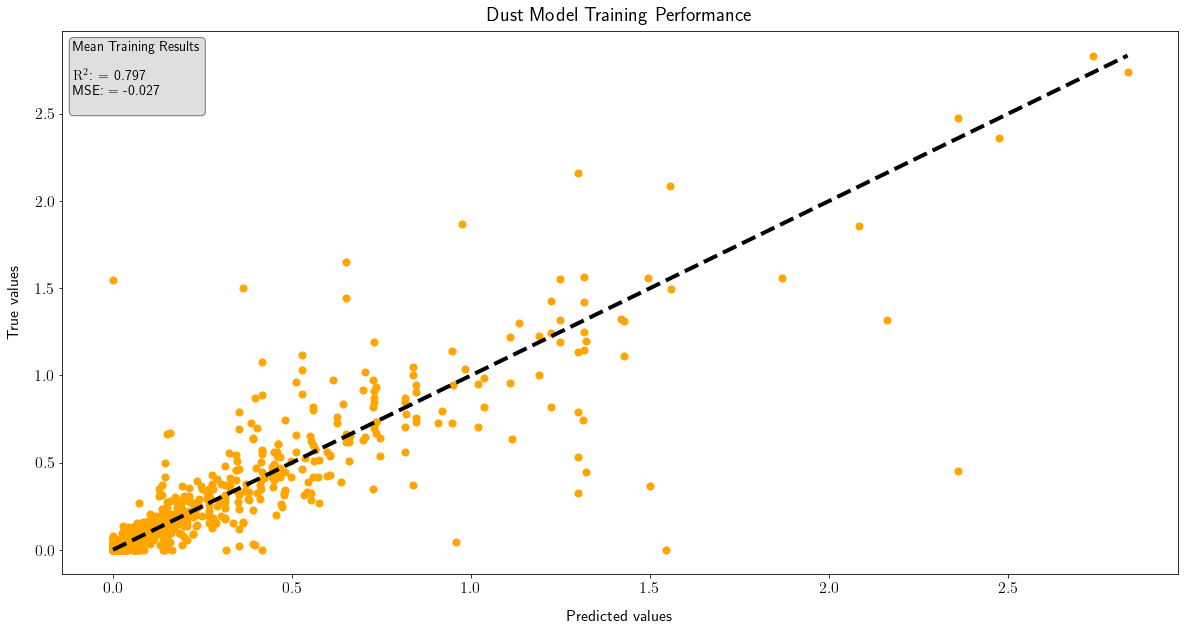

In [60]:
dust_model = DecisionTreeRegressor(max_features=800)
cv_scores = cross_validate(dust_model, spectra, dust, cv=cv, scoring=['r2', 'neg_mean_squared_error'], n_jobs=-1, return_estimator=True)
prediction = cross_val_predict(dust_model, spectra, dust, cv=cv, n_jobs=-1)

estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()]

scores = {
     '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
     'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
}

plot_model_training_performance(dust, prediction, label='Dust', scores=scores, save_fig=True)

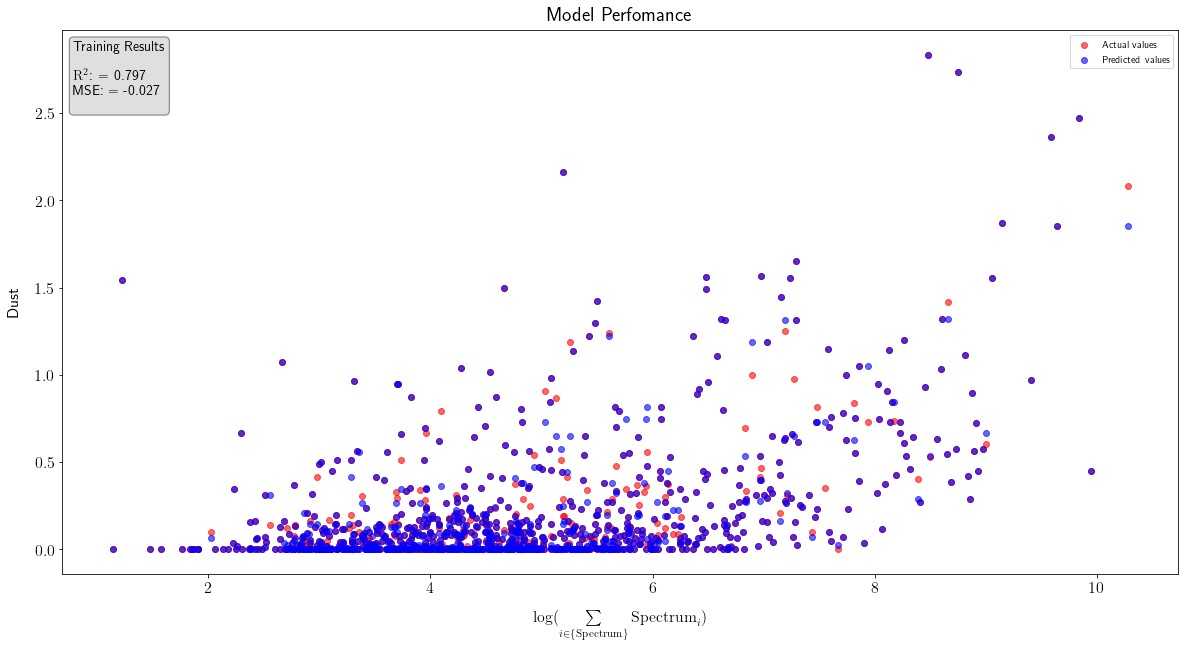

In [61]:
plot_model_performance(spectra_X, dust, estimator.predict(spectra), 'Dust', scores=scores, save_fig=True)

## ADDING NOISE

In [62]:
import scipy.stats

def add_noise(df, percent):
    """
    Add a percetange of noise to a Pandas DataFrame.
    Returns a new Pandas DataFrame containing the noise.
    
    Positional arguments:
    - df : a Pandas DataFrame
    - percent: percentage of noise desired, as a float. 
               For example, a value of 0.10 is 10%. 
               Similarly a value of 1.15 is 115%. 
    """
    ndf = pd.DataFrame()
    for i in range(len(df.columns)):
        mean = df[i] * percent
        gauss_dist = scipy.stats.norm.rvs(loc=0, scale=0.005, size=1000)
        ndf[i] = df[i] + np.abs(gauss_dist)
        
    return ndf

In [85]:
def plot_noise_together(model, target, label, cv, scoring=['r2', 'neg_mean_squared_error']):
    noisy_spectra = [spectra_1, spectra_5, spectra_10]
    
    plots = np.empty(3)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    reg_ax = fig.add_subplot(231)
    noisy_ax1 = fig.add_subplot(234)
    noisy_ax2 = fig.add_subplot(235)
    noisy_ax3 = fig.add_subplot(236)
    noisy_axes = [noisy_ax1, noisy_ax2, noisy_ax3]
    
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

    ax.set_xlabel("Wavelength (Å)", fontsize=18, labelpad=18)
    ax.set_ylabel("Flux ($\mathrm{\mu}$Jy)", fontsize=18, labelpad=36)
    ax.set_title("Data Visualization", fontsize=24, pad=40)
    
    noisy_ax1.set_title("Spectrum for Galaxy \#" + str(rows[0]), fontsize=16)
    noisy_ax2.set_title("Spectrum for Galaxy \#" + str(rows[1]), fontsize=16)
    noisy_ax3.set_title("Spectrum for Galaxy \#" + str(rows[2]), fontsize=16)
    
    cv_scores = cross_validate(model, spectra, target, cv=cv, scoring=scoring, n_jobs=-1, return_estimator=True) #Regular without noise
    prediction = cross_val_predict(model, spectra, target, cv=cv, n_jobs=-1)
    estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()]

    scores = {
        '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
        'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
    }

    plot_model_training_performance(target, prediction, label=label, scores=scores, axis=reg_ax)
    
    for i,spectrum in enumerate(noisy_spectra):
        cv_scores = cross_validate(model, spectrum, target, cv=cv, scoring=scoring, n_jobs=-1, return_estimator=True)
        prediction = cross_val_predict(model, spectrum, target, cv=cv, n_jobs=-1)
        estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()]
        
        scores = {
            '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
            'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
        }
        
        plot_model_training_performance(target, prediction, label=label, scores=scores, axis=noisy_axes[i])
        
    plt.subplots_adjust(hspace=0.4)
    fig.savefig(label + " Noise Performance")

In [86]:
spectra_1 = add_noise(spectra, 0.01)
spectra_5 = add_noise(spectra, 0.05)
spectra_10 = add_noise(spectra, 0.1)

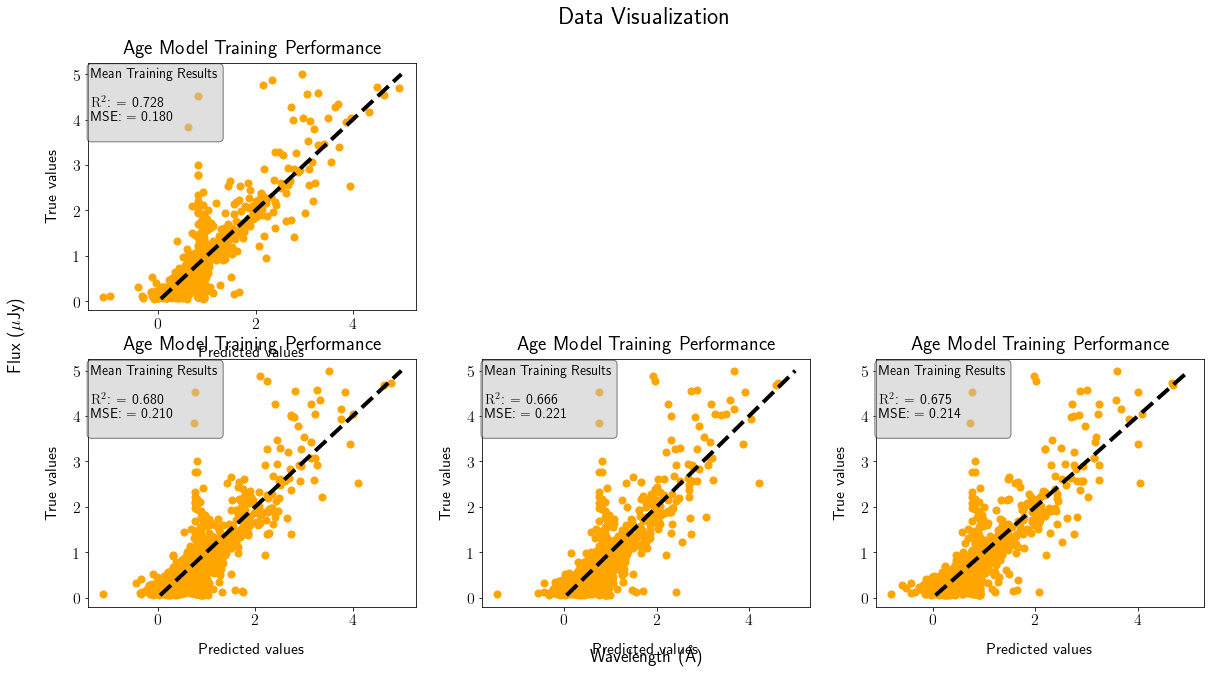

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [87]:
plot_noise_together(age_model, ages, "Age", cv)

In [ ]:
plot_model_performance(X, ages, age_model.predict(spectra_5), 'Age')
print("mse: ", mean_squared_error(ages, age_model.predict(spectra)))
print("mse noise: ", mean_squared_error(ages, age_model.predict(spectra_5)))

In [ ]:
plot_model_performance(X, ages, age_model.predict(spectra_10), 'Age')

In [ ]:
plot_model_performance(X, tau, tau_model.predict(spectra_1), 'Tau')

In [ ]:
plot_model_performance(X, tau, tau_model.predict(spectra_5), 'Tau')

In [ ]:
plot_model_performance(X, tau, tau_model.predict(spectra_10), 'Tau')

In [ ]:
plot_model_performance(X, mass, mass_model.predict(spectra_1), 'Mass')

In [ ]:
plot_model_performance(X, mass, mass_model.predict(spectra_5), 'Mass')

In [ ]:
plot_model_performance(X, mass, mass_model.predict(spectra_10), 'Mass')

In [ ]:
plot_model_performance(X, dust, dust_model.predict(spectra_1), 'Dust')

In [ ]:
plot_model_performance(X, dust, dust_model.predict(spectra_5), 'Dust')

In [ ]:
plot_model_performance(X, dust, dust_model.predict(spectra_10), 'Dust')